# L1 Norm Linear Inversion/Regression

In fields such as physics, statistics and data science, <a href="https://en.wikipedia.org/wiki/Linear_regression" target="_blank">linear regression</a>/inversion is one of the most common methods used to model data. The term regression is more commonly used in statistics and data science, while the term inversion is more commonly used in geophysics. Despite the difference in naming conventions, the underlying mathematics is the same which we will explore in this post.

## Ordinary Least Squares (L2 Norm Linear Regression)

Linear models assume that the observed data __d__ has a linear relationship with the model parameters __m__ according to the linear relation __d__ = __Gm__, where __G__ is the regression kernel. From __d__ and __G__, the aim is to find the appropriate __m__ which can explain the behavior of __d__.

Generally, most linear regression methods attempt to minimize the mean squared error _E_ = (__d__ - __Gm__)<sup>T</sup>(__d__ - __Gm__) between the data and the model predictions for over determined problems. Such linear regression methods are called ordinary least squares methods as they involve the square of the error, and assume that the distribution of both the data d and the model parameters m obey Gaussian statistics. Note that the mean squared error error is also termed the L2 norm error.

For ordinary least squares regression, the model parameters for an over determined problem can be easily calculated using the analytical solution: __m__ = [__G__<sup>T</sup>__G__]<sup>-1</sup>__G__<sup>T</sup>__d__. The Python code below demonstrates how to implement this analytical solution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog

import warnings
warnings.filterwarnings("ignore")

def least_squares(G, d):
    m = np.dot(np.linalg.inv(np.dot(G.T, G)), G.T)
    m = np.dot(m, d)
    return m

## L1 Norm Linear Regression

However, there are cases where the Gaussian distribution assumption does not always hold. For example the observed data points might obey an exponential distribution instead. Linear regression methods based on the exponential distribution attempt to minimize the mean absolute error _E_ = |__d__ - __Gm__| between the data and the predictions instead, and due to the exponential distribution assumption are much more tolerant of outlier data points as compared to ordinary least squares. Note that the mean absolute error is also called the L1 norm error.

Unlike L2 norm linear regression, L1 norm linear regression do not have an analytical solution, and we have to resort to numerical solutions. One common method used to solve L1 norm regression is the linear programming method, where we cast the regression in the following form. 

We assume a linear relationship between the data vector __d__ with size _N_×1 and the model parameters vector __m__ with size _M_×1 given by:

__d__ = __Gm__ 

with inversion kernel matrix __G__ with size _N_×_M_. We want to minimize the mean absolute error weighted by the standard deviation of the data σ: 

_E_ = |__d__ - __Gm__|(1/σ), 

subject to the constraints: 

__Gm__<sub>1</sub> - __Gm__<sub>2</sub> + __x__<sub>1</sub> - __α__ = __d__,

__Gm__<sub>1</sub> - __Gm__<sub>2</sub> - __x__<sub>2</sub> + __α__ = __d__, 


__m__<sub>1</sub> ≥ 0, __m__<sub>2</sub> ≥ 0, __x__<sub>1</sub> ≥ 0, __x__<sub>2</sub> ≥ 0, __α__ ≥ 0, 

where: 

__α__ = |__d__ - __Gm__|, __m__ = __m__<sub>1</sub> - __m__<sub>2</sub>, and __m__<sub>1</sub>, __m__<sub>2</sub>, __x__<sub>1</sub> and __x__<sub>2</sub> are additional parameters required to convert the linear relation into a linear programming problem.

The linear programming equations above are represented by the following vectors and matrices: 

1. __x__ = [[__m__<sub>1</sub>], [__m__<sub>2</sub>], [__α__], [__x__<sub>1</sub>], [__x__<sub>2</sub>]] with size 3 _N_ + 2 _N_ × 1,

2. _f_ = [[__0__<sub>M×1</sub>], [__0__<sub>M×1</sub>], [1/σ], [__0__<sub>N×1</sub>], [__0__<sub>N×1</sub>]] with sub-matrix sizes corresponding to those in __x__,

3. __A__<sub>eq</sub> = [[__G__, -__G__, -__1__<sub>N×N</sub>, __1__<sub>N×N</sub>, __0__<sub>N×N</sub>], [__G__, -__G__, __1__<sub>N×N</sub>, __0__<sub>N×NM/sub>, -__1__<sub>N×N</sub>]] with size 2 _N_ × 3 _N_ + 2 _M_,

4. __b__<sub>eq</sub> = [[__d__], [__d__]] with size 2 _N_ × 1,

5. __A__ = __1__<sub>3N+2M×3N+2M</sub>], [__1__<sub>2M×3N+2M</sub>]] with size 3 _N_ + 4 _M_ × 3 _N_ + 2 _M_,

6. __b__ = [[__0__<sub>3N+2M×1</sub>], [__m__<sub>up</sub>]] with size 3 _N_ + 4 _M_ × 1, where __m__<sub>up</sub> is the upper bound of the model parameters __m__.

This linear programming problem can then be solved numerically. The Python L1 norm linear regression solver below for the over determined case is adapted from the MATLAB code in <a href="https://www.amazon.co.jp/-/en/William-Menke/dp/B074R6RNNN/ref=sr_1_1?dchild=1&keywords=Geophysical+Data+Analysis%3A+Discrete+Inverse+Theory+MATLAB+Edition+Third+Edition&qid=1604754561&sr=8-1" target="_blank">Geophysical Data Analysis: Discrete Inverse Theory MATLAB Edition, Third Edition, William Menke</a>.

In [2]:
def l1_norm_inversion(G, d, sd = None):
    """
    Linear inversion using L1 norm error instead 
    of mean squared error for over determined problems.
    The inversion problem is transformed into a 
    linear programming problem and solved using the 
     linprog() function from scipy.optimize.
    See Geophysical Data Analysis: Discrete Inverse 
    Theory MATLAB Edition Third Edition by William 
    Menke pages 153-157 for more details.
    
    Inputs
    ------
    G: np.array
        np.array of the inversion kernel. 
        Equivalent to X in scikit-learn api.
    d: np.array
        np.array of observations. 
        Equivalent to y in scikit-learn api.
    sd: np.array
        std of the measurement d. 
        Set to 1 by default.
        
    Returns
    -------
    mest_l1: np.array
        np.array of the inverted model parameters
    """
    # If the std of the measurement d was not provided,
    # set it to 1.
    if sd is None:
        sd = np.ones(len(d))
    
    N, M = np.shape(G)
    L = 2 * M + 3 * N

    # 1. Create f containing the inverse data std:
    f = np.zeros(L)
    f[2*M:2*M+N] = 1 / sd

    # Make Aeq and beq for the equality constraints:
    Aeq = np.zeros([2*N, L])
    beq = np.zeros(2*N)
    
    Aeq[:N, :M] = G
    Aeq[:N, M:2*M] = -G
    Aeq[:N, 2*M:2*M+N] = -np.eye(N)
    Aeq[:N, 2*M+N:2*M+2*N] = np.eye(N)
    beq[:N] = d
    
    Aeq[N:2*N, :M] = G
    Aeq[N:2*N, M:2*M] = -G
    Aeq[N:2*N, 2*M:2*M+N] = np.eye(N)
    Aeq[N:2*N, 2*M+2*N:2*M+3*N] = -np.eye(N)
    beq[N:2*N] = d
    
    # Make A and b for the >=0 constraints:
    A = np.zeros([L+2*M, L])
    b = np.zeros(L+2*M)
    A[:L, :] = -np.eye(L)
    b[:L] = np.zeros(L)
    
    A[L:L+2*M] = np.eye(2*M, L)
    # For this example, we use the least squares solution
    # as the upper bound for the model parameters.
    mls = least_squares(G, d)
    mupperbound = 10 * np.max(np.abs(mls))
    b[L:L+2*M] = mupperbound
    
    res = linprog(f, A, b, Aeq, beq)
    
    # The output res = [m1, m2, alpha, x1, x2]. 
    # Extract m1 and m2 and calculate the model 
    # parameters using m = m1 - m2.
    mest_l1 = res['x'][:M] - res['x'][M:2*M]
    return mest_l1

As part of this demonstration, we attempt to invert the model parameters of the quadratic equation _f_(_x_) = 3<i>x</i><sup>2</sup> - _x_ + 2. We include an outlier data point in the data to demonstrate the difference between how the two solutions behave. The solutions are shown in the graph below.

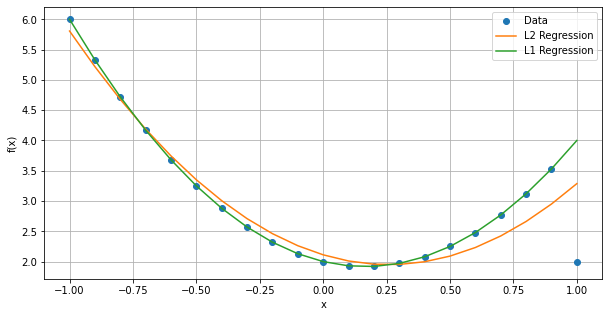

In [3]:
x = np.arange(-1.0, 1.0+0.1, 0.1)
y = 3 * x ** 2 - x + 2
y[-1] = 2

mest_l2 = least_squares(np.vander(x, 3), y)
mest_l1 = l1_norm_inversion(np.vander(x, 3), y)

plt.figure(figsize = (10, 5))
plt.plot(x, y, "o")
plt.plot(x, mest_l2[0] * x**2 + mest_l2[1] * x + mest_l2[2])
plt.plot(x, mest_l1[0] * x**2 + mest_l1[1] * x + mest_l1[2])
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend(["Data", "L2 Regression", "L1 Regression"])
plt.show()

In [4]:
print(mest_l2)
print(mest_l1)

[ 2.43534726 -1.25974026  2.11180124]
[ 3. -1.  2.]


Note that the L2 solution (ordinary least squares regression) is affected by the outlier data point due to the assumption that the data obeys Gaussian statistics and returns:

_f_(_x_) = 2.44<i>x</i><sup>2</sup> - 1.26 _x_ + 2.11, 

while the L1 solution is not and returns a more accurate solution:

_f_(_x_) = 3<i>x</i><sup>2</sup> - _x_ + 2. 

The linear programming method is not necessarily the best method to perform L1 norm regression, but it does work quite nicely although sometimes the numerical solver gets stuck so multiple runs might be needed to get a reasonable solution. 

If you are using `tensorflow`, then L1 norm regression models can be built using `tf.keras.losses.MeanAbsoluteError` as the model's loss function. In addition, `sklearn`'s linear_model library also contains various models which are able to deal with more complex loss function such as the Huber loss which combines the best of both L1 and L2 norm errors.

For more details regarding L1 norm inversion/regression, I recommend <a href="https://www.amazon.co.jp/-/en/William-Menke/dp/B074R6RNNN/ref=sr_1_1?dchild=1&keywords=Geophysical+Data+Analysis%3A+Discrete+Inverse+Theory+MATLAB+Edition+Third+Edition&qid=1604754561&sr=8-1" target="_blank">Geophysical Data Analysis: Discrete Inverse Theory MATLAB Edition, Third Edition, William Menke</a> where the mathematical details are covered in greater detail, in addition to demonstrating a L1 norm solver for the under determined case.